# Week 37: Language Models
This section implements 3 different language models: a Unigram-model, a Bigram-model and a Long short-term memory network. The perplexity for each of the models can be found in the report.

In [ ]:
%%capture
!pip3 install datasets
!pip3 install googletrans==3.1.0a0
!pip3 install torch
!pip3 install tabulate
!pip3 install nltk
!pip3 install matplotlib
!pip3 install mpld3
!pip2 install optuna
!pip3 install bpemb

In [ ]:
import numpy as np
import pandas as pd
import random
import sys
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from functools import partial

import matplotlib.pyplot as plt
from bpemb import BPEmb
from datasets import DatasetDict
from tabulate import tabulate
from tqdm.notebook import tqdm
from typing import Tuple
import abc
import collections

import nltk
nltk.download('punkt')
nltk.download('stopwords')
sys.path.append("/statnlpbook")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# GPU
device = torch.device("cpu")
if torch.cuda.is_available():
  device = torch.device("cuda")
device


### Loading the dataset

In [ ]:
%run dict_maker.py
languages = ['indonesian', 'bengali', 'arabic']
train_set_dict = train_set_dict
val_set_dict = val_set_dict

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Import Success


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/116067 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13325 [00:00<?, ? examples/s]

Adding  indonesian to dict


Filter:   0%|          | 0/116067 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13325 [00:00<?, ? examples/s]

Adding  bengali to dict


Filter:   0%|          | 0/116067 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13325 [00:00<?, ? examples/s]

Adding  arabic to dict


Filter:   0%|          | 0/116067 [00:00<?, ? examples/s]

Filter:   0%|          | 0/13325 [00:00<?, ? examples/s]


Tokenizing question, answer and document text for indonesian


Map:   0%|          | 0/11394 [00:00<?, ? examples/s]

Map:   0%|          | 0/1191 [00:00<?, ? examples/s]

Done


Tokenizing question, answer and document text for bengali


Map:   0%|          | 0/4779 [00:00<?, ? examples/s]

Map:   0%|          | 0/224 [00:00<?, ? examples/s]

Done


Tokenizing question, answer and document text for arabic


Map:   0%|          | 0/29598 [00:00<?, ? examples/s]

Map:   0%|          | 0/1902 [00:00<?, ? examples/s]

Parameter 'function'=<function <lambda> at 0x7d79685e9630> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Done

Removing stopwords


Map:   0%|          | 0/11394 [00:00<?, ? examples/s]

Map:   0%|          | 0/4779 [00:00<?, ? examples/s]

Map:   0%|          | 0/29598 [00:00<?, ? examples/s]

Map:   0%|          | 0/1191 [00:00<?, ? examples/s]

Map:   0%|          | 0/224 [00:00<?, ? examples/s]

Map:   0%|          | 0/1902 [00:00<?, ? examples/s]

### Aux functions

In [ ]:
# Creating BOW
def unique_words(data):
  word_to_ix = {}
  for sent in data:
      for word in sent:
          if word not in word_to_ix:
              word_to_ix[word] = len(word_to_ix)
  return word_to_ix

In [ ]:
# Creating trainable data
def oracle(data, language):
  labels = []
  for elem in data[language]:
      if elem['annotations']['answer_text'][0] == '':
          labels.append(0)
      else:
          labels.append(1)
  return labels

In [ ]:
first_column_VAL = [item['answer_text'][0] for item in val_set_dict['indonesian']['annotations']]
labels_VAL = []
for elem in first_column_VAL:
    if elem == '':
        labels_VAL.append(0)
    else:
        labels_VAL.append(1)

## Preparing the aux-models

We are 3 members in the group

In [ ]:
# Amount of members in the group
k = 3

We implement an abstract class LanguageModel, as they also do in the language_models.ipynb file.
Here we define init functions:

Vocab: our vocabulary (train set).

Order: history length (-1)

We also define a probability function. The purpose of the function is to calculate the conditional probability of seeing a given word based on the history of previous words.

In [ ]:
class LanguageModel(metaclass=abc.ABCMeta):
    """
    Args:
        vocab: the vocabulary underlying this language model. Should be a set of words.
        order: history length (-1).
    """
    def __init__(self, vocab, order):
        self.vocab = vocab
        self.order = order

    @abc.abstractmethod
    def probability(self, word,*history):
        """
        Args:
            word: the word we need the probability of
            history: words to condition on.
        Returns:
            the probability p(w|history)
        """
        pass

# Uniform Language Model

We define a class Uniform Language Model that takes our LanguageModel as an input. In the class UniformLM we define a probability function, that assigns a probability to each word in our vocab. We divide the total probability-mass of 1.0 by the length of our vocab. If the word is not in the vocabulary we assign the probability of 0.

In [ ]:
class UniformLM(LanguageModel):
    """
    A uniform language model that assigns the same probability to each word in the vocabulary.
    """
    def __init__(self, vocab):
        super().__init__(vocab, 1)
    def probability(self, word,*history):
        return 1.0 / len(self.vocab) if word in self.vocab else 0.0

We define the perplexity function which determines the quality of our models.

In [ ]:
import math
def perplexity(lm, data):
    """
    Calculate the perplexity of the language model given the provided data.
    Args:
        lm: a language model.
        data: the data to calculate perplexity on.

    Returns:
        the perplexity of `lm` on `data`.

    """
    log_prob = 0.0
    history_order = lm.order - 1
    for i in range(history_order, len(data)):
        history = data[i - history_order : i]
        word = data[i]
        p = lm.probability(word, *history)
        log_prob += math.log(p) if p > 0.0 else float("-inf")
    return math.exp(-log_prob / (len(data) - history_order))

Extracting document words and question words for our models:

In [ ]:
#Extracting doc_words for each language
doc_words_indo_train =  [item for items in train_set_dict['indonesian']['doc_text_words'] for item in items]
doc_words_beng_train =  [item for items in train_set_dict['bengali']['doc_text_words'] for item in items]
doc_words_arab_train =  [item for items in train_set_dict['arabic']['doc_text_words'] for item in items]

doc_words_indo_test =  [item for items in val_set_dict['indonesian']['doc_text_words'] for item in items]
doc_words_beng_test =  [item for items in val_set_dict['bengali']['doc_text_words'] for item in items]
doc_words_arab_test =  [item for items in val_set_dict['arabic']['doc_text_words'] for item in items]

In [ ]:
#Extracting question_words for each language
qn_words_indo_train =  [item for items in train_set_dict['indonesian']['question_words'] for item in items]
qn_words_beng_train =  [item for items in train_set_dict['bengali']['question_words'] for item in items]
qn_words_arab_train =  [item for items in train_set_dict['arabic']['question_words'] for item in items]

qn_words_indo_test =  [item for items in val_set_dict['indonesian']['question_words'] for item in items]
qn_words_beng_test =  [item for items in val_set_dict['bengali']['question_words'] for item in items]
qn_words_arab_test =  [item for items in val_set_dict['arabic']['question_words'] for item in items]


In [ ]:
# Testing
print(doc_words_indo_train[10:20])
print(doc_words_beng_train[10:20])
print(doc_words_arab_train[10:20])
print(doc_words_indo_test[10:20])
print(doc_words_beng_test[10:20])
print(doc_words_arab_test[10:20])
print(qn_words_indo_train[10:20])
print(qn_words_beng_train[10:20])
print(qn_words_arab_train[10:20])
print(qn_words_indo_test[10:20])
print(qn_words_beng_test[10:20])
print(qn_words_arab_test[10:20])

['nisannya', '29', 'Agustus', '1950', 'versi', 'van', 'der', 'Veur', '2006', 'dimakamkan']
['–আগস্ট', '১৮', '১২২৭', 'প্রধান', 'মঙ্গোল', 'রাজনৈতিক', 'ও', 'সামরিক', 'নেতা', 'বা']
['وجود', 'العثمانيين', 'المسلمين', 'أوروبا', 'وطردهم', 'واستعادة', 'القسطنطينية', 'العثمانيين', 'سقوطها', '1453']
['orang-orang', 'Viking', 'Eropa', 'Utara', 'berkunjung', 'Amerika', 'Utara', 'abad', '11', 'mendirikan']
['জর্জ', 'ফাইভ', 'এবং', 'কুনি', 'মেরি', 'মুম্বাই', 'আগমনের', 'স্মৃতি', 'রক্ষার্থে', 'নির্মাণ']
['فازت', 'بالبطولة', '8', 'فرق،', 'ويعد', 'المنتخب', 'البرازيلي', 'الأكثر', 'تتويجاً', 'بالكأس']
['Kota', 'Seoul', 'PBB', 'terbentuk', 'Dimana', 'James', 'Hepburn', 'meninggal', 'Dimana', 'Jamie']
['ছিলেন', 'কত', 'সালে', 'সর্বভারতীয়', 'তৃণমূল', 'কংগ্রেসের', 'প্রতিষ্ঠা', 'হয়', 'কত', 'সালে']
['المسلمين', 'سوريا؟', 'تاسست', 'السلفية', 'الجهادبة', 'مصر', '؟', 'ريتشارد', 'دوكينز؟', 'ضريبة']
['meninggal', 'luas', 'kah', 'samudera', 'pasifik', 'denga', 'geisha', 'Bank', 'BCA', 'mengeluarkan']
['স্থাপত্যটির', 

## N-gram models

In [ ]:
class CountLM(LanguageModel):
    """
    A Language Model that uses counts of events and histories to calculate probabilities of words in context.
    """
    @abc.abstractmethod
    def counts(self, word_and_history):
        pass
    @abc.abstractmethod
    def norm(self, history):
        pass

    def probability(self, word, *history):
        sub_history = tuple(history[-(self.order-1):]) if self.order > 1 else ()
        return self.counts((word,) + sub_history) / self.norm(sub_history)

In [ ]:
# This function that assigns probability to seeing n-words after eachother
class NGramLM(CountLM):
    def __init__(self, train, order):
        """
        Create an NGram language model.
        Args:
            train: list of training tokens.
            order: order of the LM.
        """
        super().__init__(set(train), order)
        self._counts = collections.defaultdict(float)
        self._norm = collections.defaultdict(float)
        for i in range(self.order, len(train)):
            history = tuple(train[i - self.order + 1 : i])
            word = train[i]
            self._counts[(word,) + history] += 1.0
            self._norm[history] += 1.0
    def counts(self, word_and_history):
        return self._counts[word_and_history]
    def norm(self, history):
        return self._norm[history]

To handle the problem of words with zero counts and solve the infinite perplexity problem, we will replace unseen words that are not in our vocabulary with the '00V'-token in the test set.

In [ ]:
# We use smoothing to replace the words out of the vocabulary to avoid infinite probability.
OOV = '[OOV]'
def replace_OOVs(vocab,data):
    """
    Replace every word not within the vocabulary with the `OOV` symbol.
    Args:
        vocab: the reference vocabulary.
        data: the sequence of tokens to replace words within

    Returns:
        a version of `data` where each word not in `vocab` is replaced by the `OOV` symbol.
    """

    return [word if word in vocab else OOV for word in data]

In [ ]:
class OOVAwareLM(LanguageModel):
    """
    This LM converts out of vocabulary tokens to a special OOV token before their probability is calculated.
    """
    def __init__(self, base_lm, missing_words, oov=OOV):
        super().__init__(base_lm.vocab | missing_words, base_lm.order)
        self.base_lm = base_lm
        self.oov = oov
        self.missing_words = missing_words

    def probability(self, word, *history):
        if word in self.base_lm.vocab:
            return self.base_lm.probability(word, *history)
        elif word in self.missing_words:
            return self.base_lm.probability(self.oov, *history) / len(self.missing_words)
        else:
            return 0.0


In [ ]:
def inject_OOVs(data):
    """
    Uses a heuristic to inject OOV symbols into a dataset.
    Args:
        data: the sequence of words to inject OOVs into.

    Returns: the new sequence with OOV symbols injected.
    """

    seen = set()
    result = []
    for word in data:
        if word in seen:
            result.append(word)
        else:
            result.append(OOV)
            seen.add(word)
    return result

In [ ]:
def sum_probabilities(lm):
    probs = sorted([(word,lm.probability(word,*())) for word in lm.vocab], key=lambda x:x[1], reverse=True)
    probabilities = [prob for _, prob in probs]
    return sum(probabilities)

def plot_probabilities(lm, context=(), how_many=10):
    probs = sorted([(word, lm.probability(word, *context)) for word in lm.vocab], key=lambda x: x[1], reverse=True)[:how_many]

    words = [word for word, _ in probs]
    probabilities = [prob for _, prob in probs]

    plt.barh(words, probabilities)
    plt.xlabel('Probability')
    plt.title('Top Probabilities')
    plt.gca().invert_yaxis()  # Reverse the order to have the highest probability at the top
    plt.show()


### Unigram-model

In [ ]:
def unigram_injection(train, test, language):
    oov_train = inject_OOVs(train)
    oov_vocab = set(oov_train)
    oov_test = replace_OOVs(oov_vocab, test)
    oov_baseline = UniformLM(oov_vocab)
    unigram = NGramLM(oov_train, 1)
    #Baseline prob
    total_probability_base = sum_probabilities(oov_baseline)
    #Unigram prob
    total_probability_uni = sum_probabilities(unigram)

    print("Unigram for: ", language)
    print("Total_probability_baseline", round(total_probability_base, 2))
    print("Total_probability_unigram", round(total_probability_uni, 2))
    print("Perplexity: ", round(perplexity(unigram, oov_test), 3))
    plot_probabilities(unigram)

Unigram for:  doc words indonesian
Total_probability_baseline 1.0
Total_probability_unigram 1.0
Perplexity:  2337.064


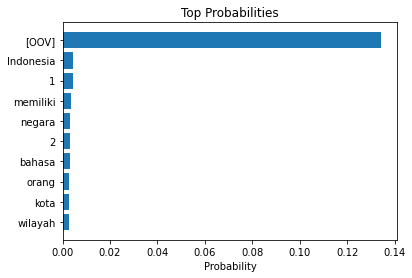

Unigram for:  doc words bengali
Total_probability_baseline 1.0
Total_probability_unigram 1.0
Perplexity:  1442.786


/usr/local/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2451 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2447 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2476 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2434 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2439 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarn

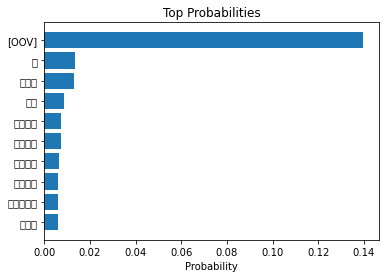

Unigram for:  doc words arabic
Total_probability_baseline 1.0
Total_probability_unigram 1.0
Perplexity:  6606.545


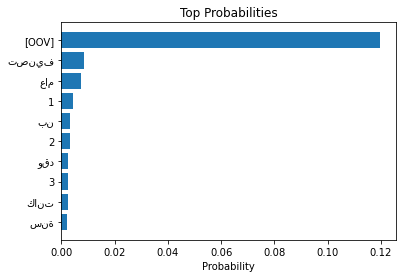

Unigram for:  qn words indonesian
Total_probability_baseline 1.0
Total_probability_unigram 1.0
Perplexity:  216.376


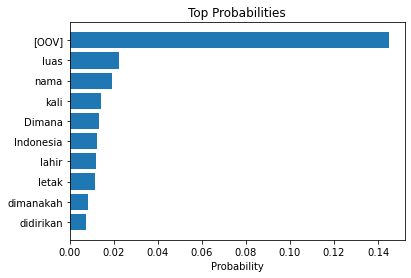

Unigram for:  qn words bengali
Total_probability_baseline 1.0
Total_probability_unigram 1.0
Perplexity:  242.267


/usr/local/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2496 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2478 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2527 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2507 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2474 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarn

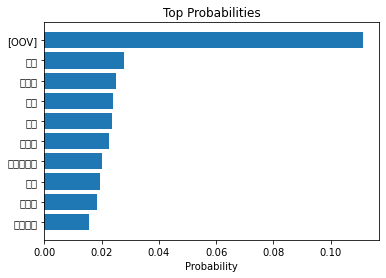

Unigram for:  qn words arabic
Total_probability_baseline 1.0
Total_probability_unigram 1.0
Perplexity:  536.163


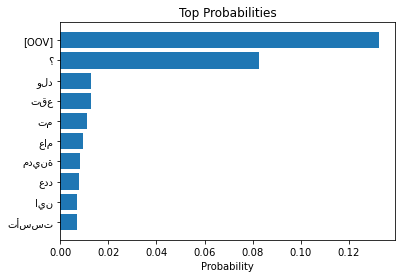

In [ ]:
unigram_injection(doc_words_indo_train, doc_words_indo_test, "doc words indonesian")
unigram_injection(doc_words_beng_train, doc_words_beng_test, "doc words bengali")
unigram_injection(doc_words_arab_train, doc_words_arab_test, "doc words arabic")

unigram_injection(qn_words_indo_train, qn_words_indo_test, "qn words indonesian")
unigram_injection(qn_words_beng_train, qn_words_beng_test, "qn words bengali")
unigram_injection(qn_words_arab_train, qn_words_arab_test, "qn words arabic")

### Bigram using Unigram

In [ ]:
class AdjustedLaplaceLM(CountLM):
    def __init__(self, base_lm, alpha):
        super().__init__(base_lm.vocab, base_lm.order)
        self.base_lm = base_lm
        self.alpha = alpha
        self.eps = 0.000001
    def counts(self, word_and_history):
        history = word_and_history[1:]
        word = word_and_history[0]
        return 0.0 if word not in self.vocab else \
               (self.base_lm.counts(word_and_history) + self.alpha) / \
               (self.base_lm.norm(history) + self.alpha * len(self.base_lm.vocab)) * \
               (self.base_lm.norm(history) + self.eps)
    def norm(self, history):
        return self.base_lm.norm(history) + self.eps


class InterpolatedLM(LanguageModel):
    def __init__(self, main, backoff, alpha):
        super().__init__(main.vocab, main.order)
        self.main = main
        self.backoff = backoff
        self.alpha = alpha
    def probability(self, word, *history):
        return self.alpha * self.main.probability(word,*history) + \
               (1.0 - self.alpha) * self.backoff.probability(word,*history)


In [ ]:
def bigram_interpolated(train, test, language):
    oov_train = inject_OOVs(train)
    oov_vocab = set(oov_train)
    oov_test = replace_OOVs(oov_vocab, test)
    unigram = NGramLM(oov_train, 1)
    bigram = NGramLM(oov_train, 2)
    adjusted_laplace_bigram = AdjustedLaplaceLM(bigram, 0.1)
    interpolated = InterpolatedLM(adjusted_laplace_bigram, unigram, 0.01)

    alphas = np.arange(0,1.1,0.1)
    perplexities = [perplexity(InterpolatedLM(adjusted_laplace_bigram,unigram,alpha),oov_test) for alpha in alphas]

    min_perplexity = min(perplexities)
    min_alpha = round(alphas[perplexities.index(min_perplexity)], 2)
    min_perplexity = round(min_perplexity, 2)

    #Sum of probabilities
    total_probability = sum_probabilities(interpolated)

    print("Bigram interpolated for: ", language)
    print("Sum of probabilities: ", round(total_probability, 2))
    print("Minimum Perplexity:", round(min_perplexity, 2))
    print("Corresponding Alpha:", round(min_alpha, 2))

    fig = plt.figure()
    plt.plot(alphas, perplexities)
    plt.scatter(min_alpha, min_perplexity, color='red', label=f'Min: ({min_alpha}, {min_perplexity})')
    plt.legend()

    plt.show()


Bigram interpolated for:  doc words indonesian
Sum of probabilities:  1.0
Minimum Perplexity: 1873.28
Corresponding Alpha: 0.3


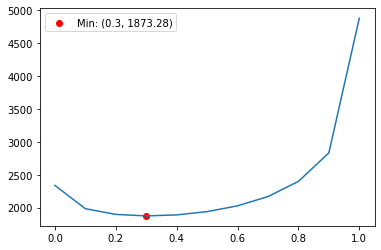

Bigram interpolated for:  doc words bengali
Sum of probabilities:  1.0
Minimum Perplexity: 1126.82
Corresponding Alpha: 0.4


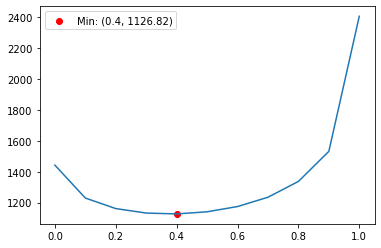

Bigram interpolated for:  doc words arabic
Sum of probabilities:  1.0
Minimum Perplexity: 4891.22
Corresponding Alpha: 0.4


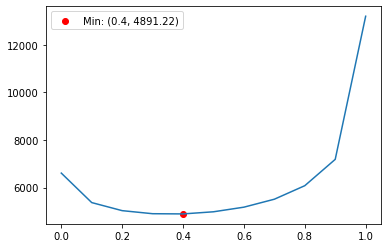

Bigram interpolated for:  qn words indonesian
Sum of probabilities:  1.0
Minimum Perplexity: 170.44
Corresponding Alpha: 0.4


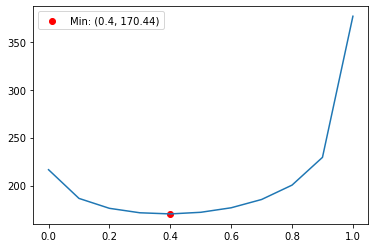

Bigram interpolated for:  qn words bengali
Sum of probabilities:  1.0
Minimum Perplexity: 131.01
Corresponding Alpha: 0.6


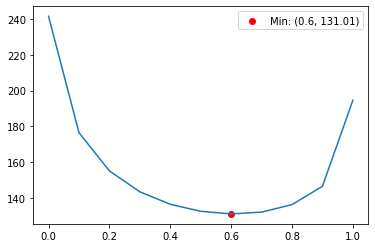

Bigram interpolated for:  qn words arabic
Sum of probabilities:  1.0
Minimum Perplexity: 369.99
Corresponding Alpha: 0.5


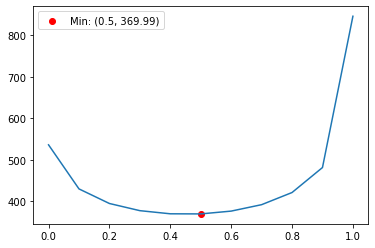

In [ ]:
bigram_interpolated(doc_words_indo_train, doc_words_indo_test, "doc words indonesian")
bigram_interpolated(doc_words_beng_train, doc_words_beng_test, "doc words bengali")
bigram_interpolated(doc_words_arab_train, doc_words_arab_test, "doc words arabic")

bigram_interpolated(qn_words_indo_train, qn_words_indo_test, "qn words indonesian")
bigram_interpolated(qn_words_beng_train, qn_words_beng_test, "qn words bengali")
bigram_interpolated(qn_words_arab_train, qn_words_arab_test, "qn words arabic")

## RNN model

For this section we followed and used the code form lab3, section RNNs. Although we have made minor adjustment to both our dataset and the storing of the result such that we could get the perplexity for each language for both question and plaintext.

In [ ]:
def enforce_reproducibility(seed=42):
    # Sets seed manually for both CPU and CUDA
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For atomic operations there is currently
    # no simple way to enforce determinism, as
    # the order of parallel operations is not known.
    # CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    random.seed(seed)
    np.random.seed(seed)

In [ ]:
enforce_reproducibility()

In [ ]:
SEED = 42
TEST_SIZE = 0.15
def create_bpemp_splits(train_dict, val_dict):
    dict_list = DatasetDict()
    for key in train_dict.keys():
        # Creating the training, validation and test data for question_text
        hugging_dict = train_dict[key].select_columns(['question_text', 'document_plaintext']).train_test_split(seed = SEED, test_size=TEST_SIZE)
        val_ds = hugging_dict.pop("test")
        hugging_dict["validation"] = val_ds
        hugging_dict['test'] = val_set_dict[key].select_columns(['question_text', 'document_plaintext'])
        dict_list[key] = hugging_dict


    return dict_list

In [ ]:
train_val_test_all = create_bpemp_splits(train_set_dict, val_set_dict)

In [ ]:
bpemb_language_map = {
    'indonesian'  : 'id',
    'bengali'     : 'bn',
    'arabic'      : 'ar'
}

vocab_bpemb = DatasetDict()

for key, value in bpemb_language_map.items():
  # We'll use again the pretrained BP Embeddings and the corresponding tokenizer.
  bpemb_ = BPEmb(lang=value, dim=100, vs=25000)
  # Extract the embeddings and add a randomly initialized embedding for our extra [PAD] token
  pretrained_embeddings = np.concatenate([bpemb_.emb.vectors, np.zeros(shape=(1,100))], axis=0)
  # Extract the vocab and add an extra [PAD] token
  vocabulary = bpemb_.emb.index_to_key + ['[PAD]']
  vocab_bpemb[key] = {"bpemb_" : bpemb_, "pretrained_embeddings" : pretrained_embeddings, "vocabulary": vocabulary}

downloading https://nlp.h-its.org/bpemb/id/id.wiki.bpe.vs25000.model


100%|██████████| 650018/650018 [00:00<00:00, 734223.32B/s]


downloading https://nlp.h-its.org/bpemb/id/id.wiki.bpe.vs25000.d100.w2v.bin.tar.gz


100%|██████████| 9465922/9465922 [00:01<00:00, 5771619.69B/s] 


downloading https://nlp.h-its.org/bpemb/bn/bn.wiki.bpe.vs25000.model


100%|██████████| 863227/863227 [00:00<00:00, 1156052.95B/s]


downloading https://nlp.h-its.org/bpemb/bn/bn.wiki.bpe.vs25000.d100.w2v.bin.tar.gz


100%|██████████| 9517491/9517491 [00:01<00:00, 5814347.34B/s]


downloading https://nlp.h-its.org/bpemb/ar/ar.wiki.bpe.vs25000.model


100%|██████████| 742254/742254 [00:00<00:00, 834070.47B/s] 


downloading https://nlp.h-its.org/bpemb/ar/ar.wiki.bpe.vs25000.d100.w2v.bin.tar.gz


100%|██████████| 9491724/9491724 [00:01<00:00, 5814560.00B/s] 


In [ ]:
for key, value in vocab_bpemb.items():
  print(key, ": ", "embeddings' shape:", value["pretrained_embeddings"].shape, "vocabulary size:", len(value["vocabulary"]))

indonesian :  embeddings' shape: (25001, 100) vocabulary size: 25001
bengali :  embeddings' shape: (25001, 100) vocabulary size: 25001
arabic :  embeddings' shape: (25001, 100) vocabulary size: 25001


In [ ]:
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
    # customize this part to your needs.
    total_length = (total_length // block_size) * block_size
    # Split by chunks of size block_size .
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    return result

block_size = 128


main_dict = DatasetDict()

for key in ['indonesian', 'bengali', 'arabic']:
  temp_dict = DatasetDict()
  for elm in ['question_text', 'document_plaintext']:

    def tokenizer(text):
          return {'input_ids': vocab_bpemb[key]['bpemb_'].encode_ids_with_eos(text)}

    def tokenize_function(examples):
          return tokenizer(examples[elm])

    tokenized_datasets = train_val_test_all[key].map(tokenize_function, batched=True, num_proc=4, remove_columns=['question_text', 'document_plaintext'])
        #print(tokenized_datasets['train'][3]['input_ids'][:10])

    lm_datasets = tokenized_datasets.map(group_texts, batched=True, batch_size=1000, num_proc=4,)

    temp_dict[elm] = {'tokenized_datasets' : tokenized_datasets, 'lm_datasets' : lm_datasets}
  main_dict[key] = temp_dict

Map (num_proc=4):   0%|          | 0/9684 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1710 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1191 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/9684 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1710 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1191 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/9684 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1710 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1191 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/9684 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1710 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1191 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/4062 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/717 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/224 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/4062 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/717 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/224 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/4062 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/717 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/224 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/4062 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/717 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/224 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/25158 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/4440 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1902 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/25158 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/4440 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1902 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/25158 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/4440 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1902 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/25158 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/4440 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/1902 [00:00<?, ? examples/s]

In [ ]:
def collate_batch_bilstm(dataset, seq_len) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Combines multiple data samples into a single batch
    :param input_ids: The token input ids
    :return: A tuple of tensors (input_ids, targets)
    """
    input_ids = [i['input_ids'] for i in dataset]

    input_lengths, padded_input = [], []
    for sentence in input_ids:
      sentence = sentence[:seq_len]
      input_lengths.append(len(sentence) - 1)
      sentence = sentence + [0] * (seq_len - len(sentence))
      padded_input.append(sentence)

    input_data = torch.tensor(padded_input)

    # we don't use the last position as there isn't anything left for generation
    input_ids = input_data[:, :-1]

    # the target at each step is to generate the next word from the sequence
    # so we shift the token ids with 1 position
    targets = input_data[:, 1:].reshape(-1)

    return input_ids, torch.tensor(input_lengths), targets

In [ ]:
torch_dl = DatasetDict()

default_seq_len = 100  # Placeholder value; adjust as necessary

for lang in main_dict.keys():
    temp_dl = DatasetDict()
    for part in main_dict[lang].keys():
        # Partially apply the collate function with the seq_len
        collate_fn_with_seqlen = partial(collate_batch_bilstm, seq_len=default_seq_len)

        test_dl = torch.utils.data.DataLoader(main_dict[lang][part]['lm_datasets']['test'], batch_size=32, collate_fn=collate_fn_with_seqlen)
        train_dl = torch.utils.data.DataLoader(main_dict[lang][part]['lm_datasets']['train'], batch_size=32, collate_fn=collate_fn_with_seqlen)
        valid_dl = torch.utils.data.DataLoader(main_dict[lang][part]['lm_datasets']['validation'], batch_size=32, collate_fn=collate_fn_with_seqlen)

        temp_dl[part] = {'test_dl': test_dl, "train_dl" : train_dl, "valid_dl" : valid_dl}

    torch_dl[lang] = temp_dl


In [ ]:
class LSTM_LM(nn.Module):
    """
    LSTM Language Model
    """
    def __init__(
            self,
            pretrained_embeddings: torch.tensor,
            lstm_dim: int,
            dropout_prob: float = 0.0,
            lstm_layers: int = 1,
    ):
        """
        Initializer for LSTM Language Model
        :param pretrained_embeddings: A tensor containing the pretrained BPE embeddings
        :param lstm_dim: The dimensionality of the BiLSTM network
        :param dropout_prob: Dropout probability
        :param lstm_layers: The number of stacked LSTM layers
        """

        # First thing is to call the superclass initializer
        super(LSTM_LM, self).__init__()

        # We'll define the network in a ModuleDict, which makes organizing the model a bit nicer
        # The components are an embedding layer, an LSTM layer, a dropout layer, and a feed-forward output layer
        self.vocab_size = pretrained_embeddings.shape[0]
        self.model = nn.ModuleDict({
            'embeddings': nn.Embedding.from_pretrained(pretrained_embeddings, padding_idx=pretrained_embeddings.shape[0] - 1),
            'lstm': nn.LSTM(
                pretrained_embeddings.shape[1],
                lstm_dim,
                num_layers=lstm_layers,
                batch_first=True,
                dropout=dropout_prob),
            'ff': nn.Linear(lstm_dim, pretrained_embeddings.shape[0]),
            'drop': nn.Dropout(dropout_prob)
        })

        # Initialize the weights of the model
        self._init_weights()

    def _init_weights(self):
        all_params = list(self.model['lstm'].named_parameters()) + \
                     list(self.model['ff'].named_parameters())
        for n, p in all_params:
            if 'weight' in n:
                nn.init.xavier_normal_(p)
            elif 'bias' in n:
                nn.init.zeros_(p)

    def forward(self, input_ids, input_lens, hidden_states):
        """
        Defines how tensors flow through the model
        :param input_ids: (b x sl) The IDs into the vocabulary of the input samples
        :param input_lens: (b x 1) The length of each instance's text
        :param hidden_states: (b x sl) x 2 Hidden states for the LSTM model
        :return: (lstm output, updated hidden stated)
        """

        # Get embeddings (b x sl x edim)
        embeds = self.model['drop'](self.model['embeddings'](input_ids))

        lstm_in = nn.utils.rnn.pack_padded_sequence(
            embeds,
            input_lens.to('cpu'),
            batch_first=True,
            enforce_sorted=False
        )

        # Pass the packed sequence through the BiLSTM
        lstm_out, hidden = self.model['lstm'](lstm_in)
        # Unpack the packed sequence --> (b x sl x 2*lstm_dim)
        lstm_out, hidden_states = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        lstm_out = self.model['drop'](lstm_out)
        # generate the prediction of each word in the vocabulary being the next
        lstm_out = self.model['ff'](lstm_out)
        lstm_out = lstm_out.reshape(-1, self.vocab_size)

        return lstm_out, hidden_states

In [ ]:
def evaluate(model: nn.Module, valid_dl: DataLoader, lstm_layers: int, batch_size: int, lstm_dim: int):
    """
    Evaluates the model on the given dataset
    :param model: The model under evaluation
    :param valid_dl: A `DataLoader` reading validation data
    :param lstm_layers: The number of LSTM layers in the model
    :param batch_size: The batch size
    :param lstm_dim: The LSTM dimension
    :return: The accuracy of the model on the dataset
    """
    # Rest of your code remains the same

    model.eval()
    loss_all = []
    states = (torch.zeros(lstm_layers, batch_size, lstm_dim).to(device),
              torch.zeros(lstm_layers, batch_size, lstm_dim).to(device))
    loss_fn = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in tqdm(valid_dl, desc='Evaluation'):
            batch = tuple(t.to(device) for t in batch)
            input_ids = batch[0]
            input_lens = batch[1]
            targets = batch[2]
            states = detach(states)
            logits, states = model(input_ids, input_lens, states)
            loss = loss_fn(logits, targets.reshape(-1))

            loss_all.append(loss.detach().cpu().numpy())

    perplexity = np.exp(sum(loss_all) / (len(loss_all)))
    return perplexity


In [ ]:
# Truncated backpropagation
def detach(states):
    return [state.detach() for state in states]

def train(
    model: nn.Module,
    train_dl: DataLoader,
    valid_dl: DataLoader,
    optimizer: torch.optim.Optimizer,
    n_epochs: int,
    device: torch.device
):
  """
  The main training loop which will optimize a given model on a given dataset
  :param model: The model being optimized
  :param train_dl: The training dataset
  :param valid_dl: A validation dataset
  :param optimizer: The optimizer used to update the model parameters
  :param n_epochs: Number of epochs to train for
  :param device: The device to train on
  :return: (model, losses) The best model and the losses per iteration
  """

  # Keep track of the loss and best accuracy
  losses = []
  best_perplexity = 2000
  # Set initial hidden and cell states
  loss_fn = nn.CrossEntropyLoss()
  # Iterate through epochs
  for ep in range(n_epochs):
    states = (torch.zeros(lstm_layers, batch_size, lstm_dim).to(device),
              torch.zeros(lstm_layers, batch_size, lstm_dim).to(device))

    loss_epoch = []

    #Iterate through each batch in the dataloader
    for batch in tqdm(train_dl):
      # VERY IMPORTANT: Make sure the model is in training mode, which turns on
      # things like dropout and layer normalization
      model.train()

      # VERY IMPORTANT: zero out all of the gradients on each iteration -- PyTorch
      # keeps track of these dynamically in its computation graph so you need to explicitly
      # zero them out
      optimizer.zero_grad()

      # Place each tensor on the GPU
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      input_lens = batch[1]
      targets = batch[2]
      # Pass the inputs through the model, get the current loss and logits
      states = detach(states)
      logits, states = model(input_ids, input_lens, states)
      loss = loss_fn(logits, targets.reshape(-1))

      losses.append(loss.item())
      loss_epoch.append(loss.item())

      # Calculate all of the gradients and weight updates for the model
      loss.backward()

      # Optional: clip gradients, helps with exploding gradients
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Finally, update the weights of the model
      optimizer.step()
      #gc.collect()

    # Perform inline evaluation at the end of the epoch
    perplexity = evaluate(model, valid_dl)
    print(f'Validation perplexity: {perplexity}, train loss: {sum(loss_epoch) / len(loss_epoch)}')

    # Keep track of the best model based on the accuracy
    best_model = model.state_dict()
    if perplexity < best_perplexity:
      best_model = model.state_dict()
      best_perplexity = perplexity

  model.load_state_dict(best_model)
  return model, losses

In [ ]:
def opt_train(
    model: nn.Module,
    train_dl: DataLoader,
    valid_dl: DataLoader,
    optimizer: torch.optim.Optimizer,
    n_epochs: int,
    device: torch.device,
    lstm_layers: int,
    batch_size: int,
    lstm_dim: int
):
    """
    The main training loop which will optimize a given model on a given dataset
    :param model: The model being optimized
    :param train_dl: The training dataset
    :param valid_dl: A validation dataset
    :param optimizer: The optimizer used to update the model parameters
    :param n_epochs: Number of epochs to train for
    :param device: The device to train on
    :param lstm_layers: The number of LSTM layers
    :param batch_size: The batch size
    :param lstm_dim: The LSTM dimension
    :return: (model, losses) The best model and the losses per iteration
    """

    # Keep track of the loss and best accuracy
    losses = []
    best_perplexity = 480.0

    # Set initial hidden and cell states
    loss_fn = nn.CrossEntropyLoss()

    # Iterate through epochs
    for ep in range(n_epochs):
        states = (
            torch.zeros(lstm_layers, batch_size, lstm_dim).to(device),
            torch.zeros(lstm_layers, batch_size, lstm_dim).to(device)
        )

        loss_epoch = []

        # Iterate through each batch in the dataloader
        for batch in tqdm(train_dl):
            # VERY IMPORTANT: Make sure the model is in training mode, which turns on
            # things like dropout and layer normalization
            model.train()

            # VERY IMPORTANT: zero out all of the gradients on each iteration -- PyTorch
            # keeps track of these dynamically in its computation graph so you need to explicitly
            # zero them out
            optimizer.zero_grad()

            # Place each tensor on the GPU
            batch = tuple(t.to(device) for t in batch)
            input_ids = batch[0]
            input_lens = batch[1]
            targets = batch[2]

            # Pass the inputs through the model, get the current loss and logits
            states = detach(states)
            logits, states = model(input_ids, input_lens, states)
            loss = loss_fn(logits, targets.reshape(-1))

            losses.append(loss.item())
            loss_epoch.append(loss.item())

            # Calculate all of the gradients and weight updates for the model
            loss.backward()

            # Optional: clip gradients, helps with exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Finally, update the weights of the model
            optimizer.step()

        # Perform inline evaluation at the end of the epoch
        perplexity = evaluate(model, valid_dl, lstm_layers, batch_size, lstm_dim)

        print(f'Validation perplexity: {perplexity}, train loss: {sum(loss_epoch) / len(loss_epoch)}')

        # Keep track of the best model based on the accuracy
        best_model = model.state_dict()
        if perplexity < best_perplexity:
            best_model = model.state_dict()
            best_perplexity = perplexity

    model.load_state_dict(best_model)
    return model, losses


In [ ]:
result_dict = DatasetDict()
for lang in torch_dl.keys():
  temp = DatasetDict()
  for part in torch_dl[lang].keys():

    # Define some hyperparameters
    lr = 0.0001
    n_epochs = 4
    lstm_dim = 2048
    lstm_layers = 4
    batch_size = 126
    seq_len = 126

    model = LSTM_LM(
        torch.FloatTensor(vocab_bpemb[lang]['pretrained_embeddings']),
        lstm_dim=lstm_dim,
        dropout_prob=0.1,
        lstm_layers=lstm_layers
      ).to(device)

    # Create the optimizer
    optimizer = Adam(model.parameters(), lr=lr)

    # Train
    model, _ = opt_train(
            model,
            torch_dl[lang][part]['train_dl'],
            torch_dl[lang][part]['valid_dl'],
            optimizer,
            n_epochs,
            device,
            lstm_layers,
            batch_size,
            lstm_dim)
    temp[part] = evaluate(
          model,
          torch_dl[lang][part]['test_dl'],
          lstm_layers,
          batch_size,
          lstm_dim)
  result_dict[lang] = temp

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Validation perplexity: 696.1902320027549, train loss: 8.505092692375182


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Validation perplexity: 533.5442918170652, train loss: 6.231857657432556


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Validation perplexity: 515.5000771302546, train loss: 6.103525233268738


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Validation perplexity: 503.687068885703, train loss: 6.055635094642639


Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/46 [00:00<?, ?it/s]

Validation perplexity: 2313.105197052981, train loss: 7.918486833572388


  0%|          | 0/248 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/46 [00:00<?, ?it/s]

Validation perplexity: 2297.785651073413, train loss: 7.70422350975775


  0%|          | 0/248 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/46 [00:00<?, ?it/s]

Validation perplexity: 2302.535445904483, train loss: 7.696233466748269


  0%|          | 0/248 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/46 [00:00<?, ?it/s]

Validation perplexity: 2300.9195195237903, train loss: 7.692999343718252


Evaluation:   0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation perplexity: 2519.6428977609166, train loss: 9.727713758295232


  0%|          | 0/11 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation perplexity: 804.0157237674937, train loss: 7.159754102880305


  0%|          | 0/11 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation perplexity: 718.1534629092221, train loss: 6.4933577450838955


  0%|          | 0/11 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/2 [00:00<?, ?it/s]

Validation perplexity: 689.4687236014086, train loss: 6.377885428341952


Evaluation:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/124 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/22 [00:00<?, ?it/s]

Validation perplexity: 3382.4537560202357, train loss: 8.362462512908444


  0%|          | 0/124 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/22 [00:00<?, ?it/s]

Validation perplexity: 3333.170778160235, train loss: 8.03083917402452


  0%|          | 0/124 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/22 [00:00<?, ?it/s]

Validation perplexity: 3329.08929576213, train loss: 8.010822192315132


  0%|          | 0/124 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/22 [00:00<?, ?it/s]

Validation perplexity: 3331.5269703482536, train loss: 8.003082863746151


Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Validation perplexity: 719.3503017021372, train loss: 7.406476533637856


  0%|          | 0/53 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Validation perplexity: 666.2151479010168, train loss: 6.4866411101143315


  0%|          | 0/53 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Validation perplexity: 650.1944741692142, train loss: 6.4294293061742245


  0%|          | 0/53 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]

Validation perplexity: 643.8300461296127, train loss: 6.40854364970945


Evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/757 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/135 [00:00<?, ?it/s]

Validation perplexity: 3321.6324553761224, train loss: 8.17673945773388


  0%|          | 0/757 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/135 [00:00<?, ?it/s]

Validation perplexity: 3321.8064987726575, train loss: 8.10228169704523


  0%|          | 0/757 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/135 [00:00<?, ?it/s]

Validation perplexity: 3337.4028077499793, train loss: 8.096837845629713


  0%|          | 0/757 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/135 [00:00<?, ?it/s]

Validation perplexity: 2297.643749306728, train loss: 8.010275949102727


Evaluation:   0%|          | 0/52 [00:00<?, ?it/s]

In [ ]:
pd.DataFrame(result_dict)

,indonesian,bengali,arabic
question_text,1252.883968,1412.620098,760.248638
document_plaintext,2493.067984,3391.397162,2391.718362


In [ ]:
pd.DataFrame(result_dict).to_csv('Training_RNN')
pd.DataFrame(best_params_dict).to_csv('param_dict')